In [1]:
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [7]:
datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

'30-10-2020_17-21-30'

In [67]:
with open('Data/traj30-10-2020_18-24-08.pkl','rb') as f:
    traj = pickle.load(f)

In [155]:
def filter_by_loc(traj,xlimit=1e6,ylimit=0):
    locs = np.array(traj['loc'])
    loc = []
    rew = []
    obs = []
    for i in range(locs.shape[0]):
        if locs[i,0]!=0 and locs[i,1]!=0:
            if locs[i,0]<xlimit and locs[i,1]>ylimit:
                loc.append(locs[i,:])
                rew.append(traj['reward'][i])
                obs.append(traj['obs'][i])
    return np.array(loc),np.array(rew),np.array(obs)

In [69]:
loc,rew,obs = filter_by_loc(traj)

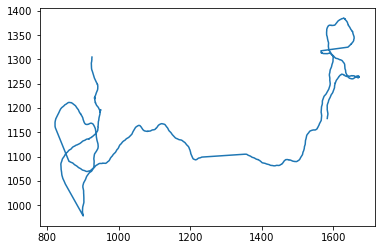

In [70]:
plt.plot(loc[:,0],loc[:,1])

In [21]:
traj.keys()

dict_keys(['loc', 't', 'endpts', 'obs', 'reward', 'target', 'action'])

In [4]:
obs = np.array(traj['obs'])

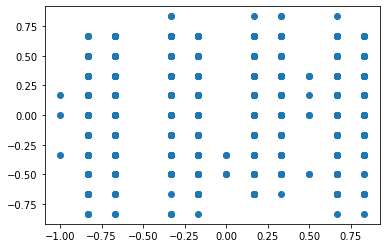

In [6]:
plt.scatter(obs[:,0],obs[:,1])

(array([343., 261.,   1., 589.,   0.,   0., 699.,   1., 331., 274.]),
 array([-8.33333333e-01, -6.66666667e-01, -5.00000000e-01, -3.33333333e-01,
        -1.66666667e-01,  1.11022302e-16,  1.66666667e-01,  3.33333333e-01,
         5.00000000e-01,  6.66666667e-01,  8.33333333e-01]),
 <BarContainer object of 10 artists>)

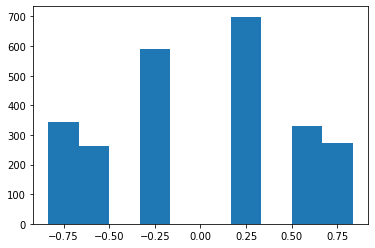

In [91]:
plt.hist(obs[:,0])

(array([  1., 112., 179., 263., 534., 301., 589., 368., 105.,  47.]),
 array([-1.        , -0.81666667, -0.63333333, -0.45      , -0.26666667,
        -0.08333333,  0.1       ,  0.28333333,  0.46666667,  0.65      ,
         0.83333333]),
 <BarContainer object of 10 artists>)

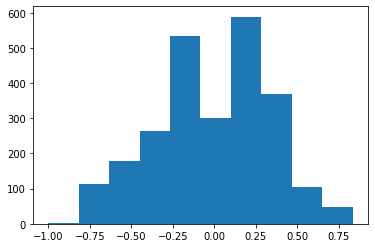

In [90]:
plt.hist(obs[:,1])

In [81]:
H, xedges, yedges = np.histogram2d(obs[:,0], obs[:,1], bins=(np.linspace(-1,1,12), np.linspace(-1,1,12)))

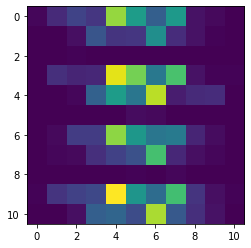

In [82]:
plt.imshow(H)

In [87]:
H, xedges, yedges = np.histogram2d(obs[:,0], obs[:,1], bins=(np.linspace(-1,1,12), np.linspace(-1,1,12)))

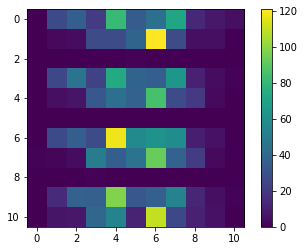

In [89]:
plt.imshow(H)
plt.colorbar()

In [5]:
obs

array([[-0.33333333, -0.16666667],
       [ 0.66666667, -0.16666667],
       [ 0.66666667, -0.33333333],
       ...,
       [ 0.16666667,  0.33333333],
       [ 0.16666667, -0.66666667],
       [ 0.16666667,  0.33333333]])

In [17]:
rew_list = [[[] for i in range(11)] for j in range(11)]

In [15]:
inds = ((obs[0,:]+1)*6).astype(int)
counts = np.zeros((11,11))
counts[inds[0],inds[1]]

0.0

In [6]:
def reward_dist(traj,sz=12):
    # Returns reward means and std for each state.
    
    def ang_to_ind(angs):
        # Maps from [-1,1] to [0,10]
        return ((angs+1)*6).astype(int)
    
    loc,rew,obs = filter_by_loc(traj)
    
    counts = np.zeros((sz,sz))
    rew_list = [[[] for i in range(sz)] for j in range(sz)]
    
    # Goes through all obs rows and keeps a running mean of associated rewards
    for i in range(obs.shape[0]):
        inds = ang_to_ind(obs[i,:])
        counts[inds[0],inds[1]] += 1
        rew_list[inds[0]][inds[1]].append(rew[i])
        
    rew_mu = np.array([[[np.mean(rew_list[i][j])] for i in range(sz)] for j in range(sz)])[:,:,0]
    rew_sem = np.array([[[np.std(rew_list[i][j])/np.sqrt(counts[i,j])] for i in range(sz)] for j in range(sz)])[:,:,0]
    
    return rew_mu.T, rew_sem.T, counts

In [7]:
rew_mu, rew_sem, counts = reward_dist(traj)

C:\Users\ccli3\Miniconda3\envs\rlkit\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ccli3\Miniconda3\envs\rlkit\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ccli3\Miniconda3\envs\rlkit\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ccli3\Miniconda3\envs\rlkit\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\ccli3\Miniconda3\envs\rlkit\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


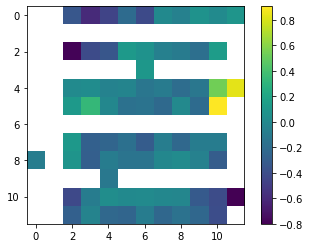

In [8]:
plt.imshow(rew_mu)
plt.colorbar()

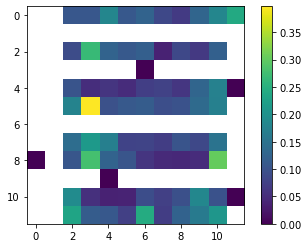

In [62]:
plt.imshow(rew_sem)
plt.colorbar()

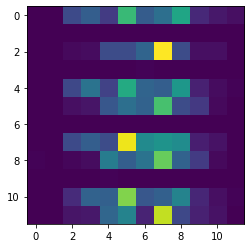

In [9]:
plt.imshow(counts)

In [187]:
def make_buffer(traj,inds=None,ahead=1):
    # Takes a trajectory and returns a memory buffer 
    # If ahead argument exists, sums up rewards from [ahead] steps
    traj = npify(traj)
    if inds is None:
        obs = traj['obs'][:-ahead]
        action = traj['action'][:-ahead]
        rew = np.array([np.sum(traj['reward'][i:i+ahead]) for i in np.arange(1,action.size)])
        next_obs = traj['obs'][1:]
    else:
        obs = traj['obs'][inds]
        action = traj['action'][inds]
        rew = np.array([np.sum(traj['reward'][i+1:i+1+ahead]) for i in inds])
        next_obs = traj['obs'][inds+1]
    buffer = {
        'obs': obs,
        'action': action,
        'reward': rew,
        'next_obs': next_obs,
        'simple': np.sign(obs[:,0]*obs[:,1])
    }
    return buffer

def npify(traj):
    return {k:np.array(v) for k,v in traj.items()}

def make_split_buffer(traj,ahead=1):
    # Takes a trajectory and returns one memory buffer where all the actions were on
    # first, and a second one where all the actions were off
    traj = npify(traj)
    on_inds = np.argwhere(traj['action'][:-1]==1).flatten()
    off_inds = np.argwhere(traj['action'][:-1]==0).flatten()
    
    on_buffer = make_buffer(traj,on_inds,ahead=ahead)
    off_buffer = make_buffer(traj,off_inds,ahead=ahead)
    return on_buffer, off_buffer

In [167]:
buff = make_buffer(traj,ahead=3)

In [177]:
onb, offb = make_split_buffer(traj)

In [8]:
from mpl_toolkits import mplot3d
%matplotlib notebook

<IPython.core.display.Javascript object>


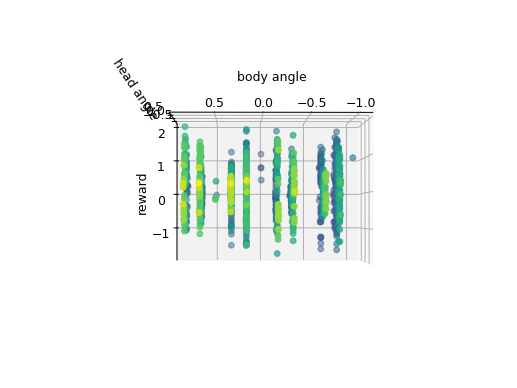

Text(0.5, 0, 'reward')

In [11]:
buffer = onb
colors = np.array(buffer['obs'])@[1,6]
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter3D(buffer['next_obs'][:,0], buffer['next_obs'][:,1], buffer['reward'], c=colors)
ax.set_xlabel('body angle')
ax.set_ylabel('head angle')
ax.set_zlabel('reward')

In [189]:
def reward_stats(buffer):
    def find_simple(buffer,simple):
        return buffer['reward'][np.argwhere(buffer['simple']==simple)]
    rews = [find_simple(buffer,i) for i in [-1,0,1]]
    r_stats = np.zeros((2,3))
    for i in range(3):
        r_stats[0,i] = np.mean(rews[i])
        r_stats[1,i] = np.std(rews[i])/np.sqrt(len(rews[i]))
    return r_stats

In [143]:
def join_buffers(b1,b2):
    return {k: np.concatenate((b1[k],b2[k]),axis=0) for k in b1.keys()}

In [215]:
# Every timestep choice
# fnames=[
#     'Data/traj30-10-2020_18-03-44.pkl',
#     'Data/traj30-10-2020_18-24-08.pkl',
#     'Data/traj02-11-2020_15-43-12.pkl',
#     'Data/traj02-11-2020_16-04-27.pkl',
#     'Data/traj03-11-2020_14-32-58.pkl',
#     'Data/traj03-11-2020_14-57-43.pkl',
# ]

# Every sec choice
fnames=[
    'Data/traj30-10-2020_18-14-00.pkl',
    'Data/traj30-10-2020_18-34-10.pkl',
    'Data/traj02-11-2020_15-53-56.pkl',
    'Data/traj02-11-2020_16-14-45.pkl',
    'Data/traj03-11-2020_14-46-45.pkl',
    'Data/traj03-11-2020_15-08-07.pkl',
]

with open(fnames[0],'rb') as f:
    traj = pickle.load(f)
for i in np.arange(1,6):
    with open(fnames[i],'rb') as f:
        traj1 = pickle.load(f)
    traj = join_buffers(traj,traj1)

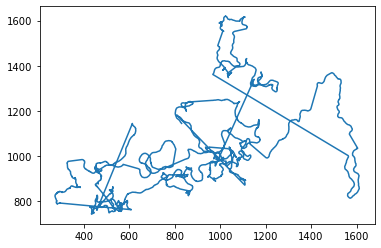

In [216]:
loc,rew,obs = filter_by_loc(traj,ylimit=200)
plt.plot(loc[:,0],loc[:,1])

### One step reward

<ErrorbarContainer object of 3 artists>

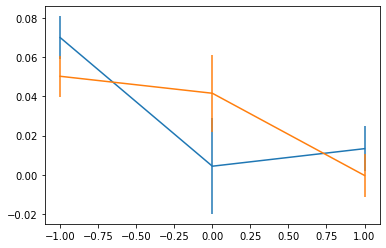

In [171]:
# For every second light choice
onb, offb = make_split_buffer(traj)
r_on_stats = reward_stats(onb)
r_off_stats = reward_stats(offb)
plt.errorbar([-1,0,1],r_on_stats[0,:],yerr=r_on_stats[1,:])
plt.errorbar([-1,0,1],r_off_stats[0,:],yerr=r_off_stats[1,:])

<ErrorbarContainer object of 3 artists>

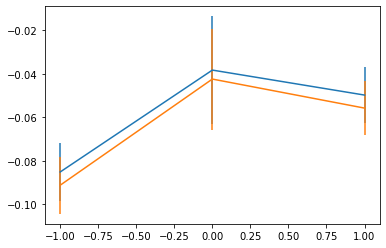

In [157]:
# For every timestep light choice
onb, offb = make_split_buffer(traj)
r_on_stats = reward_stats(onb)
r_off_stats = reward_stats(offb)
plt.errorbar([-1,0,1],r_on_stats[0,:],yerr=r_on_stats[1,:])
plt.errorbar([-1,0,1],r_off_stats[0,:],yerr=r_off_stats[1,:])

### More step rewards

<ErrorbarContainer object of 3 artists>

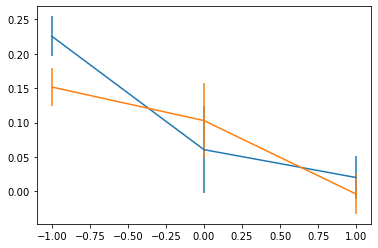

In [190]:
# For every second light choice
onb, offb = make_split_buffer(traj,ahead=3)
r_on_stats = reward_stats(onb)
r_off_stats = reward_stats(offb)
plt.errorbar([-1,0,1],r_on_stats[0,:],yerr=r_on_stats[1,:])
plt.errorbar([-1,0,1],r_off_stats[0,:],yerr=r_off_stats[1,:])

<ErrorbarContainer object of 3 artists>

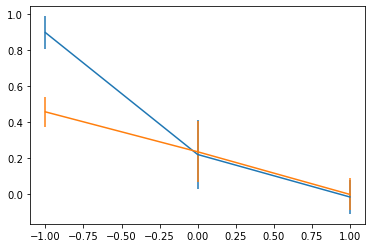

In [192]:
# ten step reward, every second light choice
onb, offb = make_split_buffer(traj,ahead=10)
r_on_stats = reward_stats(onb)
r_off_stats = reward_stats(offb)
plt.errorbar([-1,0,1],r_on_stats[0,:],yerr=r_on_stats[1,:])
plt.errorbar([-1,0,1],r_off_stats[0,:],yerr=r_off_stats[1,:])

<ErrorbarContainer object of 3 artists>

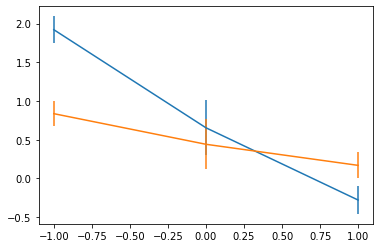

In [203]:
# ten step reward, every second light choice
onb, offb = make_split_buffer(traj,ahead=20)
r_on_stats = reward_stats(onb)
r_off_stats = reward_stats(offb)
plt.errorbar([-1,0,1],r_on_stats[0,:],yerr=r_on_stats[1,:])
plt.errorbar([-1,0,1],r_off_stats[0,:],yerr=r_off_stats[1,:])

<ErrorbarContainer object of 3 artists>

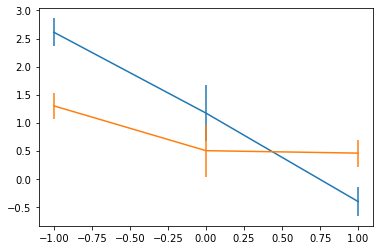

In [217]:
# ten step reward, every second light choice
onb, offb = make_split_buffer(traj,ahead=30)
r_on_stats = reward_stats(onb)
r_off_stats = reward_stats(offb)
plt.errorbar([-1,0,1],r_on_stats[0,:],yerr=r_on_stats[1,:])
plt.errorbar([-1,0,1],r_off_stats[0,:],yerr=r_off_stats[1,:])

<ErrorbarContainer object of 3 artists>

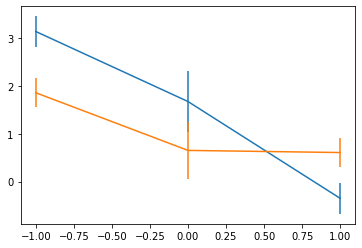

In [218]:
# ten step reward, every second light choice
onb, offb = make_split_buffer(traj,ahead=40)
r_on_stats = reward_stats(onb)
r_off_stats = reward_stats(offb)
plt.errorbar([-1,0,1],r_on_stats[0,:],yerr=r_on_stats[1,:])
plt.errorbar([-1,0,1],r_off_stats[0,:],yerr=r_off_stats[1,:])

<ErrorbarContainer object of 3 artists>

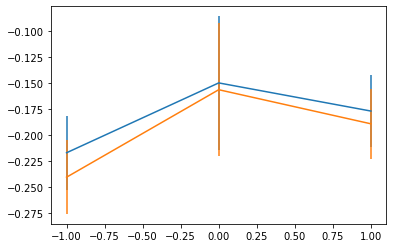

In [195]:
# For every step light choice
onb, offb = make_split_buffer(traj,ahead=3)
r_on_stats = reward_stats(onb)
r_off_stats = reward_stats(offb)
plt.errorbar([-1,0,1],r_on_stats[0,:],yerr=r_on_stats[1,:])
plt.errorbar([-1,0,1],r_off_stats[0,:],yerr=r_off_stats[1,:])

<ErrorbarContainer object of 3 artists>

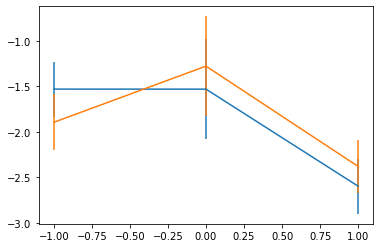

In [214]:
# ten step reward, every step light choice
onb, offb = make_split_buffer(traj,ahead=30)
r_on_stats = reward_stats(onb)
r_off_stats = reward_stats(offb)
plt.errorbar([-1,0,1],r_on_stats[0,:],yerr=r_on_stats[1,:])
plt.errorbar([-1,0,1],r_off_stats[0,:],yerr=r_off_stats[1,:])